# Distributed Learning

## Table of Contents
---
### 1. Data Parallel
### 2. Distributed Data Parallel

--------------------------------------
## Difference between Data Parallel and Distributed Data Parallel

In PyTorch,
- Both `DataParllel` and `DistributedDataParallel` allows data parallelism, i.e. splitting mini-batch dataset into different GPUs.
- `DataParllel` is a single-process and multi-thread, while `DistributedDataParallel` is multi-process.
    - Meaning in`DistributedDataParllel`, each process dedicates each GPU. 
    - Due to Python [GIL (Global Interpreter Lock)](https://realpython.com/python-gil/), only one thread gains the control of Python interpreter for each process. 
- `DataParallel` works only in a single machine, while `DistributedDataParallel` works on single and multiple machine. 
- If model size is too large to fit in single GPU, splitting model (model parallelism) is required. `DistributedDataParralel` works with model parallelism, while `DataParallel` cannot.  

## 2. DataParallel

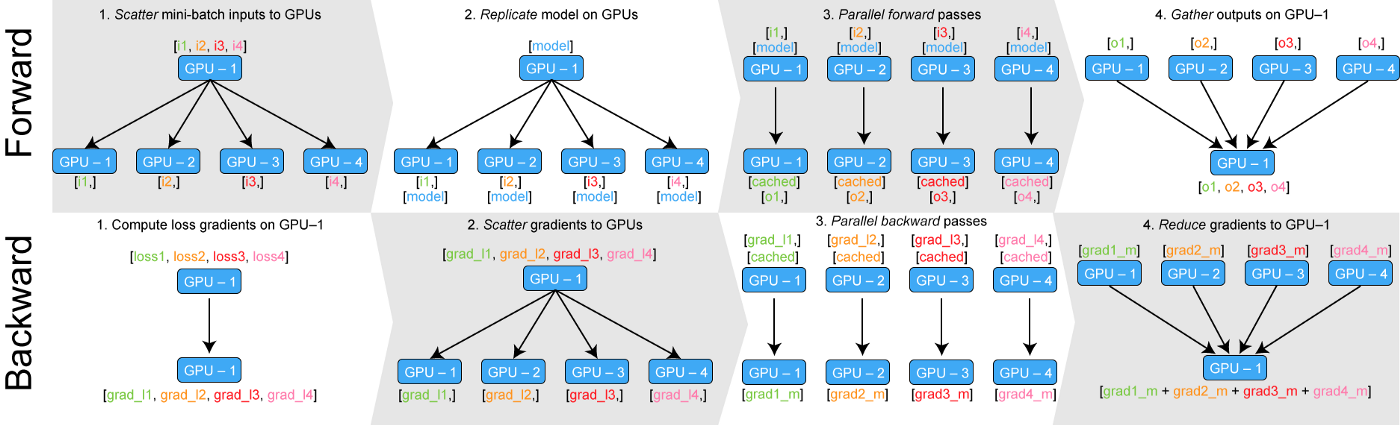
- Images from [here](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255)

`DataParallel` enables single-machine multi-GPU training.

```
torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)

---
module (torch.nn.Module) - your network on torch.nn.Module
device_ids (list of int or torch.device) - which devices you'll work with (default is set to use all devices)
output_device (int or torch.device) - where your output will be collected (default is set to be the first device)
dim - the dimension of tensor to be scattered (default is to be set on 0, which is the batch dimension)
```



In PyTorch, it is relatively easy employing `DataParllel` as shown below

In [ ]:
import torch
import torchvision

model = torchvision.models.resnet50(weights=None).cuda()

# Apply Data Parallel to model defined above.
model = torch.nn.DataParallel(model)

Let's say we will using 4 GPUs (each device ids are 0, 1, 2, 3) and collecting all the losses in second GPU (1):

In [ ]:
# Apply Data Parallel using 4 GPUs and collecting the losses in second GPU
model = torch.nn.DataParallel(model, device_ids=[0,1,2,3], output_device=1)

Let's see the running example here: https://github.com/UNIST-LIM-Lab-course/multi-gpu/blob/main/main_dp.py.

In Summary,

- Using `DataParallel`, the output is gathered to one GPU (`gather`) and compute the gradients.

- After gradients from different GPUs are computed, the backpropagation is done separately, and the separate gradients are reduced into one GPU (`reduce`).

    - `gather` and `reduce` does not seem efficient.


## 3. Distributed Data Parallel

- The main difference between `DataParallel` and `DistributedDataParallel` is whether it is working on single process or **multi process**.

- `DistributedDataParallel` do not `gather` the output and `reduce` the gradients into one GPU; it rather computes the loss and updates the model parameters individually.

- We call this `all_gather` and `all_reduce`.
    - `all_gather` copies tensors from all processes to shared tensor list in all processes.
    - `all_reduce` applies some operation on tensors and the results are stored in all processes.

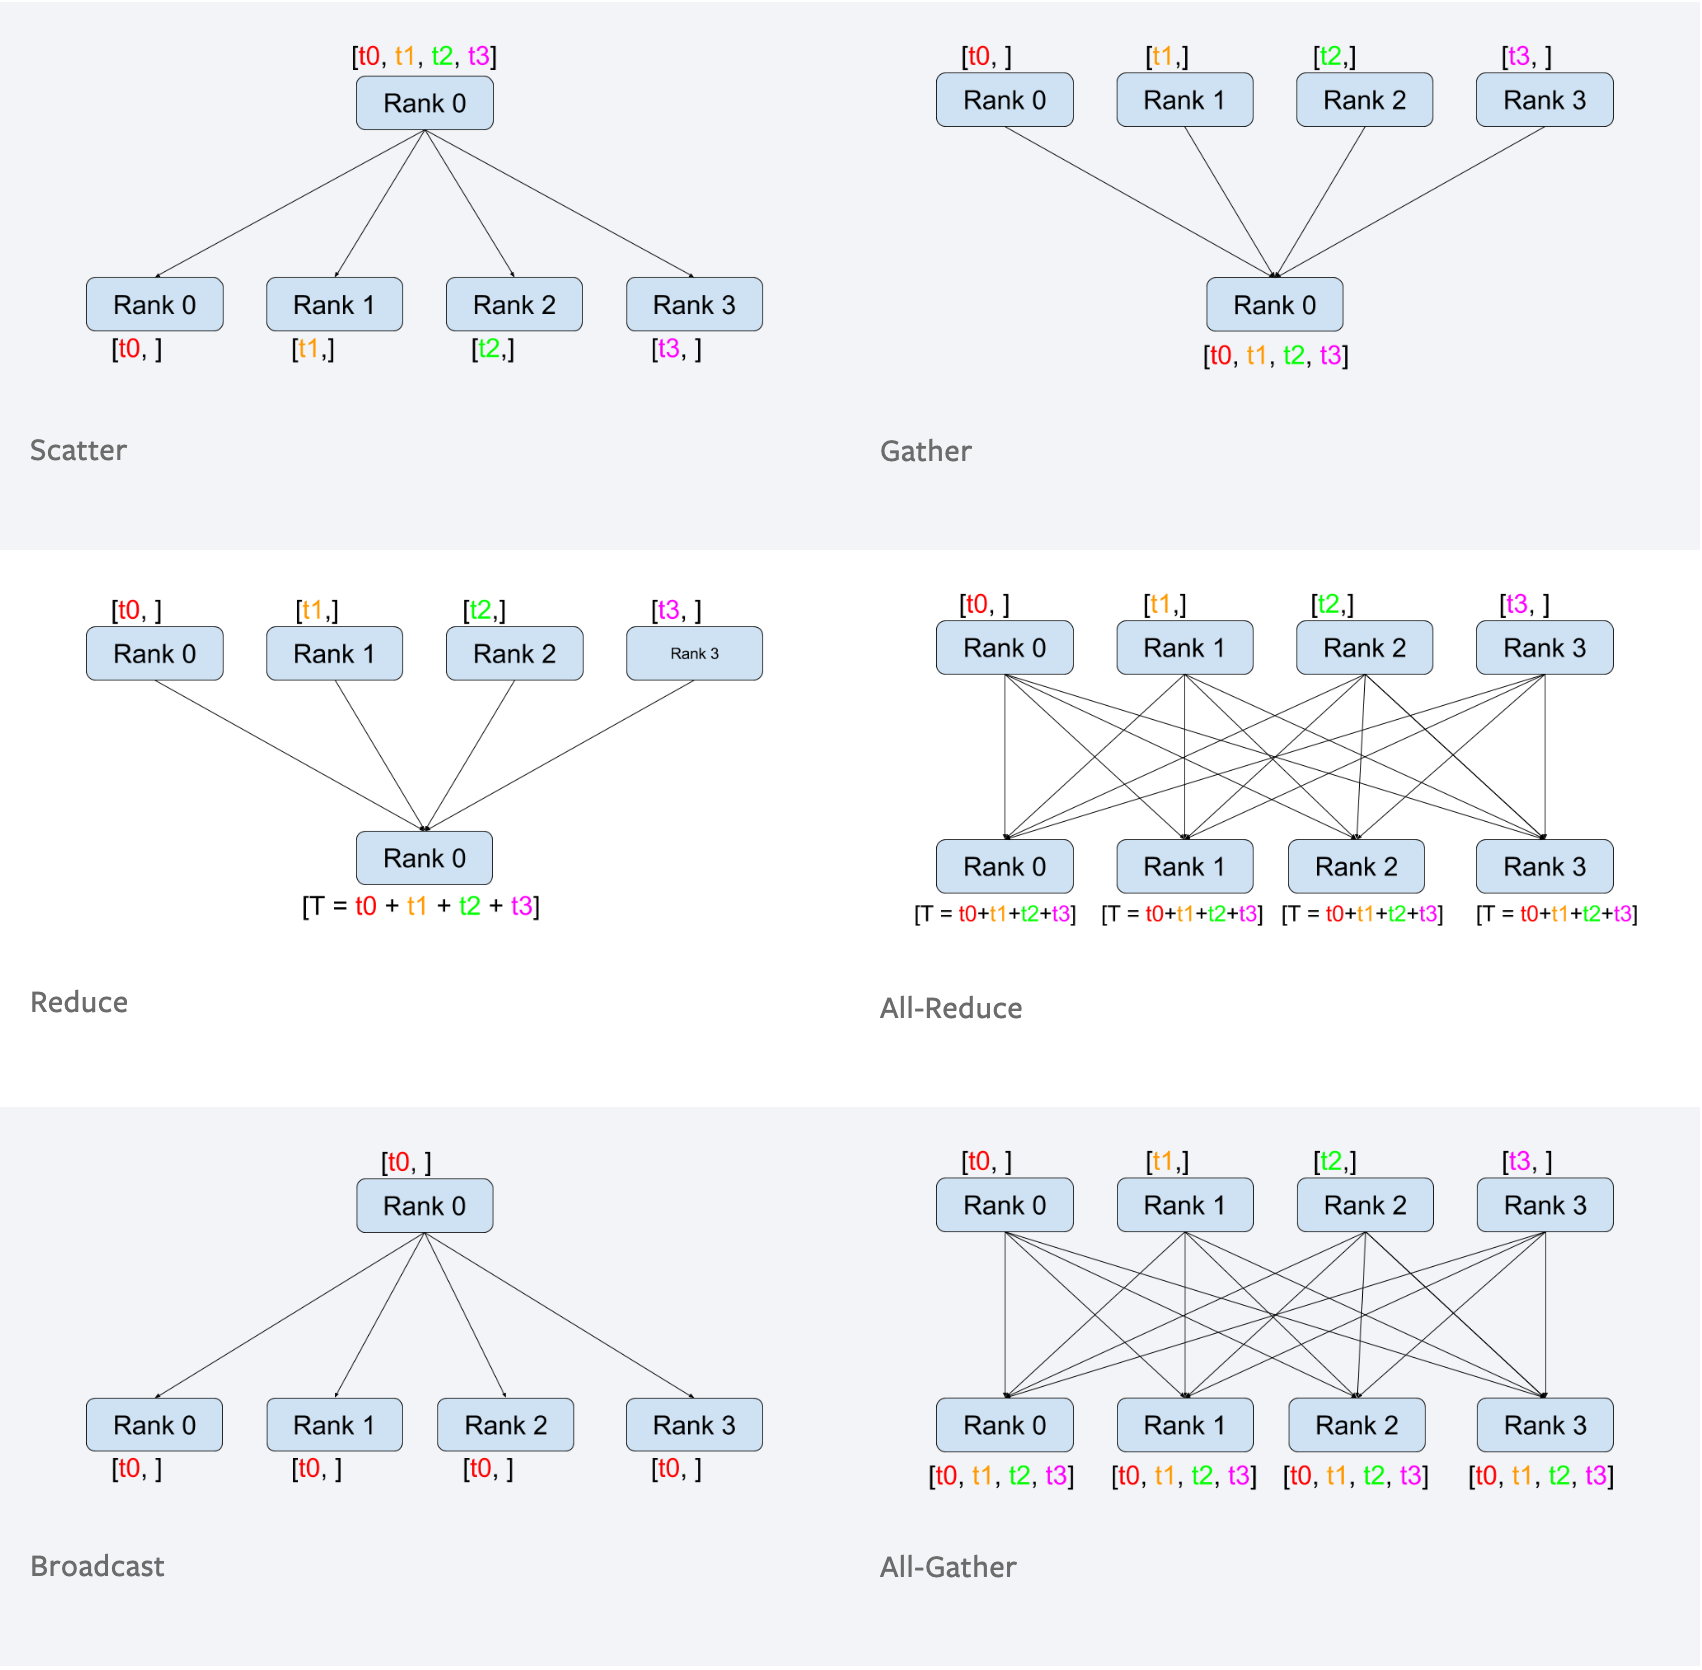
- Images from [here](https://pytorch.org/tutorials/intermediate/dist_tuto.html)

In PyTorch, using `DistributedDataParallel` is complicated than `DataParallel`.
- Initialize process pool.
- Distributing dataset into each GPU.
- Distributing the model parameters into each GPU.

In [ ]:
import torch.distributed as dist
import os

# Initialize Process Groups
dist.init_process_group(backend='nccl')

# Set the rank for each processes
local_rank = int(os.environ["LOCAL_RANK"])

# Assign GPUs sholud be used together with `CUDA_VISIBLE_DEVICES` environment variable in script
torch.cuda.set_device(local_rank)

# Get the total number of GPUs to be used - used for distributing data
world_size = torch.distributed.get_world_size() 

In [ ]:
dataset = torchvision.dataset.CIFAR100()

# Split the data with respect to the world_size (total number of GPUs)
# Each GPU will be assign divided portion of dataset -> Q, Then does each GPU will get the same training indices?
# If the dataset is not evenly divisible by the world_size, then you can drop the remainder by setting `drop_last=True`, which is default
# Otherwise, `drop_last=False` will get extra portions of data by generating similar batch_sized data
sampler = dist.DistributedSampler(dataset, num_replicas=world_size, rank=local_rank, drop_last=False)

dataloader = torch.utils.data.DataLoader(dataset, sampler=sampler)

In [ ]:
model = torchvision.models.resnet50(weights=None).cuda()

# Apply Distributed Data Parallel to the model defined above
model = torch.nn.parallel.DistributedDataParallel(model,
                                                  device_ids=[local_rank],
                                                  output_device=local_rank)

Launching DDP model, you need to modify the scipt as follows:
1. For single-machine multi-processing distributed training:

    If your PyTorch version < 1.9, use `torch.distributed.launch`

    ```script
    $ python3 -m torch.distributed.launch --nproc_per_node=NUMBER_OF_GPUS PYTHON_SCRIPT.py --arg1 --arg2
    ```

    If your PyTorch version >= 1.9, use either `torch.distributed.launch` or `torchrun` from TorchElastic.

    ```
    $ torchrun --standalone --nnodes=NUM_NODES --nproc_per_node=NUMBER_OF_GPUS PYTHON_SCRIPT.py --arg1 --arg2
    ```

2. For multi-machine multi-processing distributed training: (let's say 2 machines or nodes)

    If your PyTorch version < 1.9, use `torch.distributed.launch`.
    
    Node 1:

    ```
    $ python3 -m torch.distributed.launch --nproc_per_node=NUMBER_OF_GPUS  
                    --nnodes=NUMBER_OF_MACHINES --node_rank=0 --master_addr=IP_Address  
                    --master_port=PORT --PYTHON_SCRIPT.py --arg1 --arg2
    ```

    Node 2:

    ```
        $ python3 -m torch.distributed.launch --nproc_per_node=NUMBER_OF_GPUS
                    --nnodes=NUMBER_OF_MACHINES --node_rank=1 --master_addr=IP_Address
                    --master_port=PORT --PYTHON_SCRIPT.py --arg1 --arg2
    ```

    If your PyTorch version >= 1.9, use either `torch.distributed.launch` or `torchrun` from TorchElastic.

    Node 1:

    ```
    $ torchrun --rdzv_back=c10d --rdzv_endpoint=HOST:PORT
            --nnodes=NUMBER_OF_MACHINES  --node_rank=0 
            --nproc_per_node=NUMBER_OF_GPUS PYTHON_SCRIPT.py --arg1 --arg2
    ```

    Node 2:

    ```
    $ torchrun --rdzv_back=c10d --rdzv_endpoint=HOST:PORT 
            --nnodes=NUMBER_OF_MACHINES --node_rank=1 
            --nproc_per_node=NUMBER_OF_GPUS PYTHON_SCRIPT.py --arg1 --arg2
    ```


Let's see the example in here: https://github.com/UNIST-LIM-Lab-course/multi-gpu/blob/main/main_ddp.py.